Ready? Let's snap a pic!


<IPython.core.display.Javascript object>

Center pixel HSV=(74,31,90). Looks like Gray. What color do you see? black
Ah, I thought it was Gray. Let's try again!
Saved it here: color_detection_results/Gray_20250520_124231.jpg
Want another go? (y/n): y


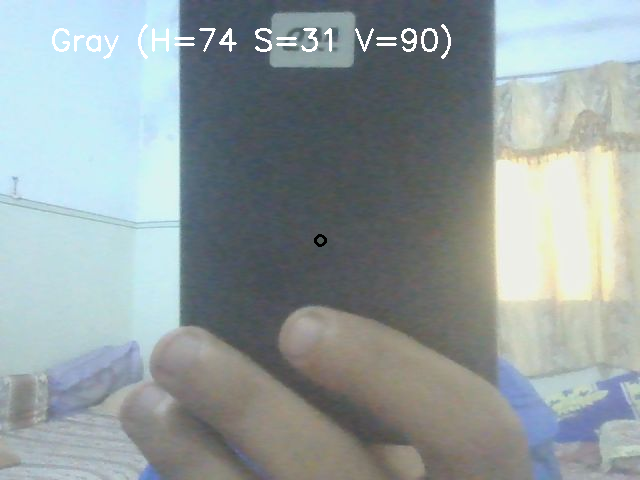

Ready? Let's snap a pic!


<IPython.core.display.Javascript object>

Center pixel HSV=(174,99,111). Looks like Red. What color do you see? red
Yay! You nailed it! 🎉
Saved it here: color_detection_results/Red_20250520_124323.jpg
Want another go? (y/n): y


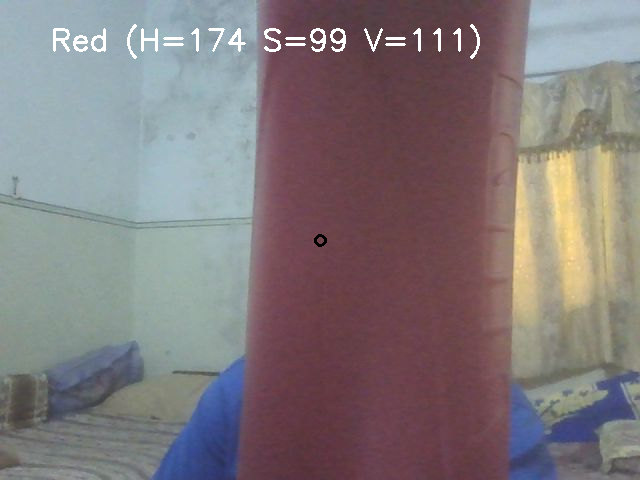

Ready? Let's snap a pic!


<IPython.core.display.Javascript object>

Center pixel HSV=(0,134,118). Looks like Red. What color do you see? red
Yay! You nailed it! 🎉
Saved it here: color_detection_results/Red_20250520_124414.jpg
Want another go? (y/n): yes


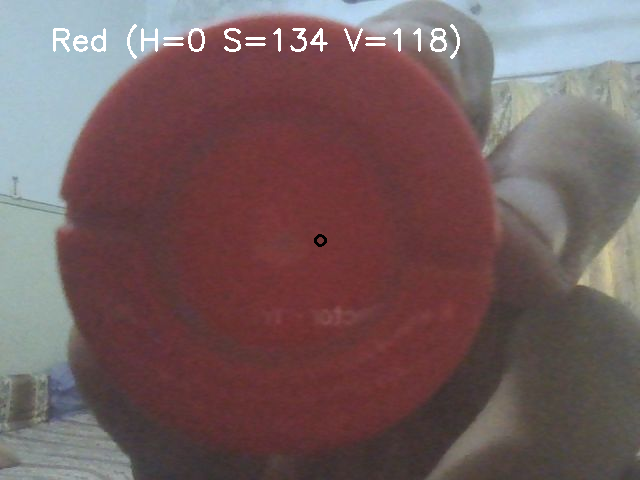

Alright, catch you later! 👋


In [2]:
import cv2
import os
from datetime import datetime

def make_folder():
    folder = "color_detection_results"
    if not os.path.exists(folder):
        os.mkdir(folder)
    return folder

def save_pic(img, color, folder):
    time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = f"{folder}/{color}_{time_str}.jpg"
    cv2.imwrite(path, img)
    return path

def setup_camera():
    from google.colab.patches import cv2_imshow
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def snap(filename="pic.jpg", quality=0.8):
        js = Javascript('''
            async function snapPhoto(quality) {
                const div = document.createElement('div');
                const btn = document.createElement('button');
                btn.textContent = 'Click to snap';
                div.appendChild(btn);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video:true});
                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                await new Promise(resolve => btn.onclick = resolve);

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
        ''')
        display(js)
        data = eval_js(f'snapPhoto({quality})')
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    return snap

def guess_color(h, s, v):
    if v < 50:
        return "Black"
    if s < 50 and v > 200:
        return "White"
    if s < 50:
        return "Gray"
    if h < 15 or h >= 165:
        return "Red"
    if h < 35:
        return "Orange"
    if h < 50:
        return "Yellow"
    if h < 85:
        return "Green"
    if h < 125:
        return "Cyan"
    if h < 145:
        return "Blue"
    if h < 165:
        return "Magenta"
    return "Unknown"

def main():
    from google.colab.patches import cv2_imshow

    folder = make_folder()
    snap = setup_camera()

    while True:
        print("Ready? Let's snap a pic!")
        filename = snap()
        img = cv2.imread(filename)

        h_img, w_img, _ = img.shape
        x, y = w_img // 2, h_img // 2

        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = hsv[y, x]

        color = guess_color(h, s, v)

        user_input = input(f"Center pixel HSV=({h},{s},{v}). Looks like {color}. What color do you see? ").strip().capitalize()

        if user_input == color:
            print("Yay! You nailed it! 🎉")
        else:
            print(f"Ah, I thought it was {color}. Let's try again!")

        label = f"{color} (H={h} S={s} V={v})"
        cv2.putText(img, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.circle(img, (x, y), 5, (0, 0, 0), 2)

        saved = save_pic(img, color, folder)
        print(f"Saved it here: {saved}")
        cv2_imshow(img)

        again = input("Want another go? (y/n): ").lower()
        if again != 'y':
            print("Alright, catch you later! 👋")
            break

if __name__ == "__main__":
    main()
